<a href="https://colab.research.google.com/github/boroju/aidl-upc-winter2024-satellite-imagery/blob/main/notebooks/jose/MODIS_ee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install odc-stac
!pip install planetary_computer
!pip install rioxarray
!pip install 'stackstac[viz]'
!pip install zen3geo
!pip install pyogrio[geopandas]
!pip install xbatcher
!pip install wxee
!pip install geedim
!pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.3.2
    Uninstalling cachetools-5.3.2:
      Successfully uninstalled cachetools-5.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which i

In [2]:
# Geospatial libraries
import pystac
import pystac_client
import planetary_computer
import rioxarray
# Deep Learning libraries
import torch
import torchdata
import zen3geo

In [3]:
print(f"pystac version: {pystac.__version__}")
print(f"planetary-computer version: {planetary_computer.__version__}")
print(f"torch version: {torch.__version__}")

print(f"torchdata version: {torchdata.__version__}")
print(f"zen3geo version: {zen3geo.__version__}")
rioxarray.show_versions()

pystac version: 1.9.0
planetary-computer version: 1.0.0
torch version: 2.1.0+cu121
torchdata version: 0.7.0
zen3geo version: 0.6.2
rioxarray (0.15.0) deps:
  rasterio: 1.3.9
    xarray: 2023.7.0
      GDAL: 3.6.4
      GEOS: 3.11.1
      PROJ: 9.0.1
 PROJ DATA: /usr/local/lib/python3.10/dist-packages/rasterio/proj_data
 GDAL DATA: /usr/local/lib/python3.10/dist-packages/rasterio/gdal_data

Other python deps:
     scipy: 1.11.4
    pyproj: 3.6.1

System:
    python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.58+-x86_64-with-glibc2.35


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import ee
import wxee

ee.Authenticate()
ee.Initialize(project='ee-joseramoncajide')

wxee.Initialize()

# Fire Progressions

*Before going deeply into Dixie widlfire ...*

**Daily Progressions from MODIS**

One of the products captured by the MODIS sensor is fire hotspot detections. We’ll use wxee to load daily hotspots for the  *2021 Caldor fire in California* and visualize them by the time of burning.

In [6]:
modis = wxee.TimeSeries("MODIS/006/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")

modis.describe()

MODIS/006/MOD14A1
	Images: 21
	Start date: 2021-08-15 00:00:00 UTC
	End date: 2021-09-04 00:00:00 UTC
	Mean interval: 1.00 days


The FireMask band contains codes indicating the confidence of fire detections. First, we’ll use map to turn those codes into binary images of fire presence, copying properties over so we don’t lose any time information.

In [7]:
fire_masks = modis.map(lambda img: img.eq(9).copyProperties(img, img.propertyNames()))
fire_masks.describe()

MODIS/006/MOD14A1
	Images: 21
	Start date: 2021-08-15 00:00:00 UTC
	End date: 2021-09-04 00:00:00 UTC
	Mean interval: 1.00 days


Now we’ll specify a bounding box around the Caldor fire and download the TimeSeries to an xarray.Dataset.

In [8]:
region = ee.Geometry.Polygon(
        [[[-120.70580745719522, 38.90798203224902],
          [-120.70580745719522, 38.51793451346024],
          [-119.90014827750772, 38.51793451346024],
          [-119.90014827750772, 38.90798203224902]]]
)

ds = fire_masks.wx.to_xarray(scale=1000, region=region, crs="EPSG:26910")
display(ds)

Requesting data:   0%|          | 0/21 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (time: 21, x: 73, y: 47)
Coordinates:
  * time         (time) datetime64[ns] 2021-08-15 2021-08-16 ... 2021-09-04
  * x            (x) float64 6.985e+05 6.995e+05 ... 7.695e+05 7.705e+05
  * y            (y) float64 4.312e+06 4.31e+06 4.31e+06 ... 4.266e+06 4.266e+06
    spatial_ref  int64 0
Data variables:
    FireMask     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

Visualizing the Progression

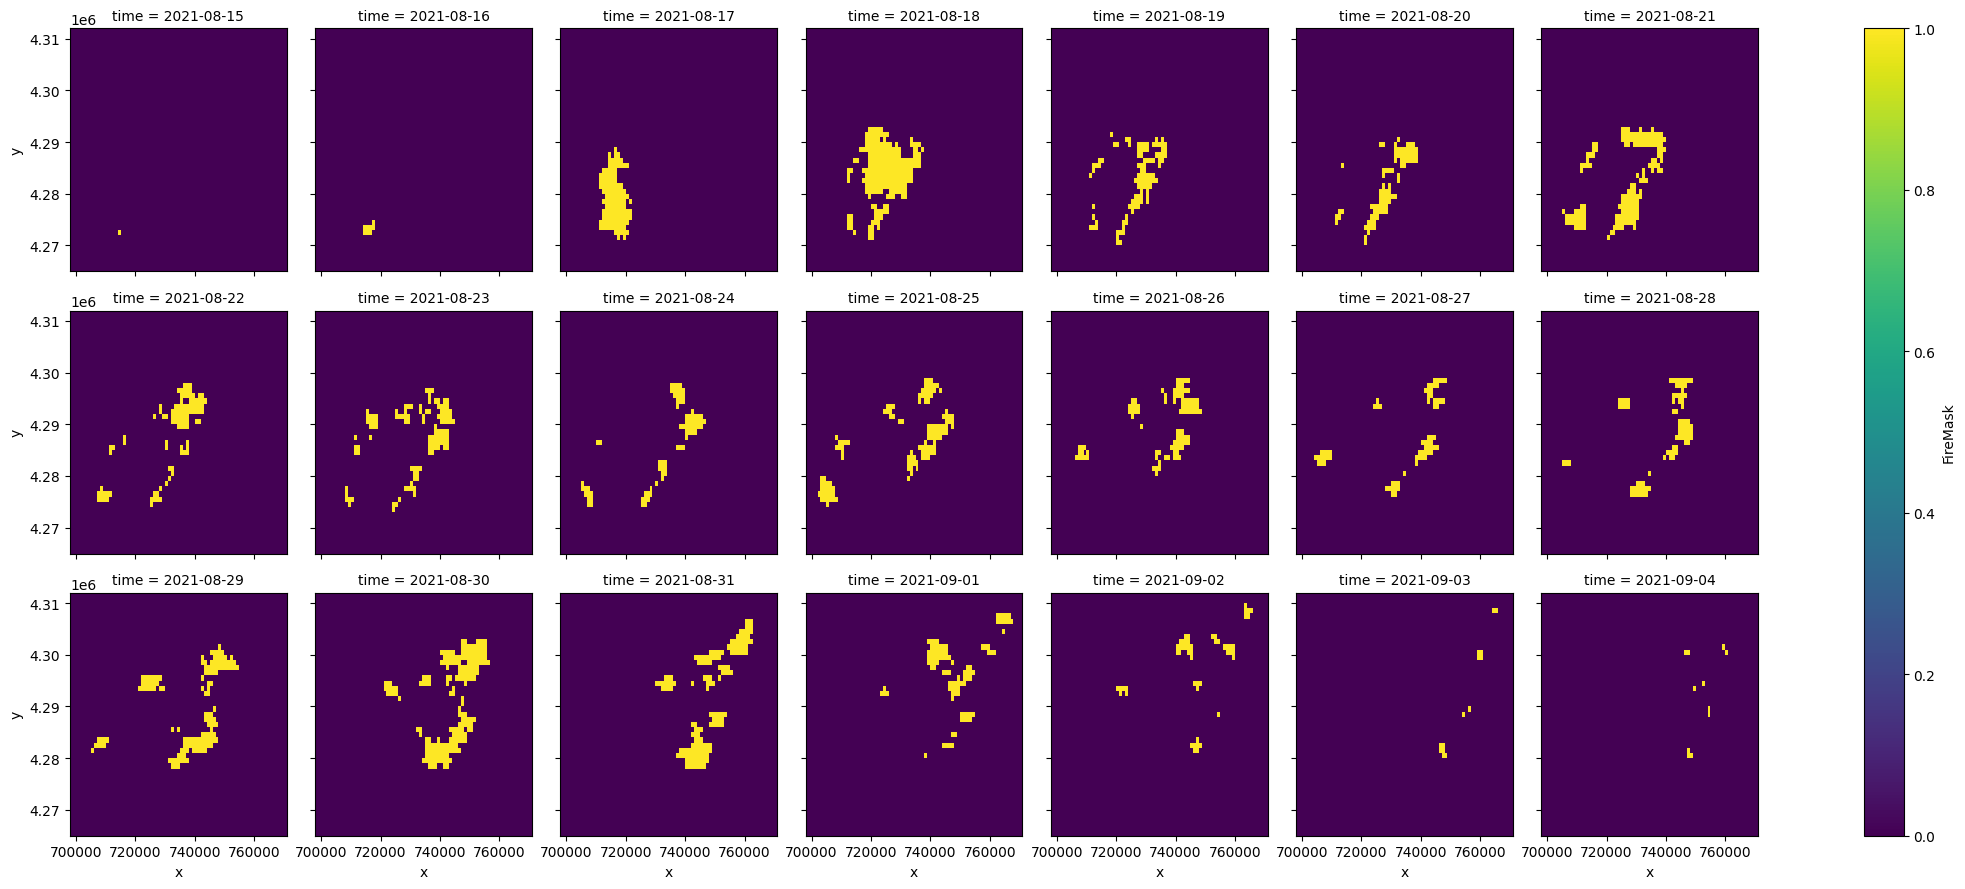

In [9]:
ds.FireMask.plot(col="time", col_wrap=7)

We want a single summary image describing that progression. Let’s calculate the first day that a given pixel burned. Rather than storing specific times, we’ll represent them as time elapsed since the beginning of the time series.

In [10]:
start = ds.time.min()
display(start)
print("")
delta_days = (ds.time - start).dt.days
display(delta_days)

<xarray.DataArray 'time' ()>
array('2021-08-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 0

<xarray.DataArray 'days' (time: 21)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])
Coordinates:
  * time         (time) datetime64[ns] 2021-08-15 2021-08-16 ... 2021-09-04
    spatial_ref  int64 0

Now, we’ll multiply the time delta by the fire mask. Because non-fire pixels have a value of 0, this will give us a 3D array with elapsed days since start for each hotspot pixel and values of 0 for all other pixels. We cast from a timedelta to an int to allow plotting.

In [11]:
delta_days_fire = (ds.FireMask * delta_days).astype(int)
display(delta_days_fire)


<xarray.DataArray (time: 21, y: 47, x: 73)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time         (time) datetime64[ns] 2021-08-15 2021-08-16 ... 2021-09-04
  * x            (x) float64 6.985e+05 6.995e+05 ... 7.695e+05 7.705e+05
  * y            (y) float64 4.312e+06 4.31e+06 4.31e+06 ... 4.266e+06 4.266e+06
    spatial_ref  int64 0

Finally, we can mask non-hotspot pixels (values of 0) and take the minimum over time to get the first time, in days elapsed since start, that each pixel burned.

In [12]:
first_burned = delta_days_fire.where(delta_days_fire != 0).min("time")
display(first_burned)

<xarray.DataArray (y: 47, x: 73)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 6.985e+05 6.995e+05 ... 7.695e+05 7.705e+05
  * y            (y) float64 4.312e+06 4.31e+06 4.31e+06 ... 4.266e+06 4.266e+06
    spatial_ref  int64 0

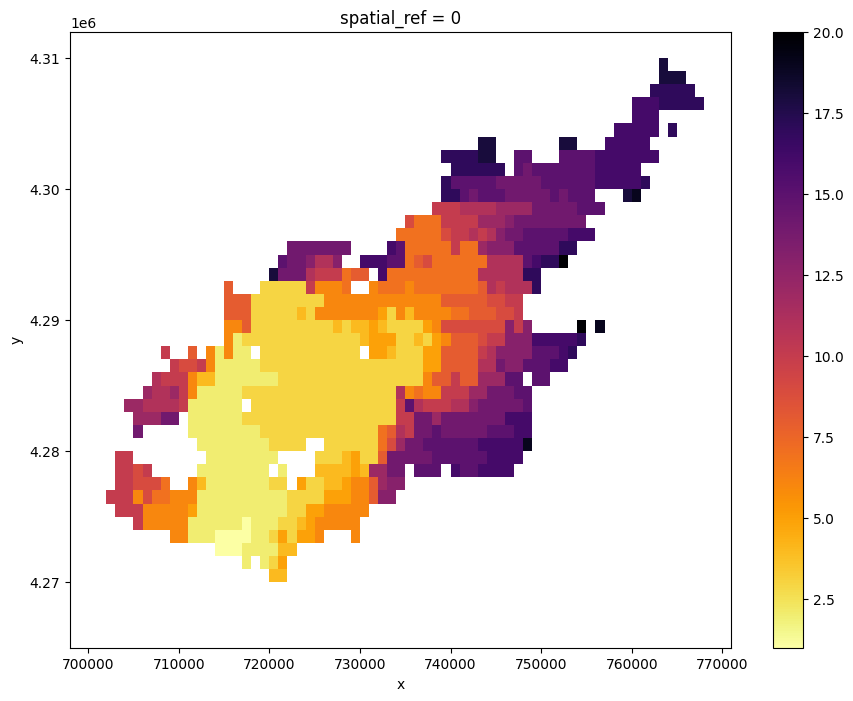

In [13]:
first_burned.plot(size=8, cmap="inferno_r")

# 2021 Dixie Wildfire in California



```
0: Not processed (missing input data)
1: Not processed (obsolete; not used since Collection 1)
2: Not processed (other reason)
3: Non-fire water pixel
4: Cloud (land or water)
5: Non-fire land pixel
6: Unknown (land or water)
7: Fire (low confidence, land or water)
8: Fire (nominal confidence, land or water)
9: Fire (high confidence, land or water)
```



In [14]:
# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
# area_of_interest or geometry
area_of_interest = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "2021-07-12",
    "2021-07-20",
    "2021-07-28",
    "2021-08-05",
    "2021-08-13",
    "2021-08-21",
]

print(area_of_interest)
buffer = 0.7
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
print(bbox)

{'type': 'Point', 'coordinates': [-122.942, 40.731]}
[-123.642, 40.031, -122.24199999999999, 41.431000000000004]


Transform bbox to Earth Engine region for later usage:

A bounding box (usually shortened to bbox) is an area defined by two longitudes and two latitudes.

In [117]:
from shapely import geometry
bbox_polygon = geometry.box(*bbox)
print(bbox_polygon.wkt)

region = ee.Geometry.Polygon(
        list(bbox_polygon.exterior.coords)
)
# print(region)

POLYGON ((-122.24199999999999 40.031, -122.24199999999999 41.431000000000004, -123.642 41.431000000000004, -123.642 40.031, -122.24199999999999 40.031))


Thermal Anomalies/Fire Daily (14A1)

Thermal Anomalies/Fire 8-Day (14A2)

In [16]:
#modis = wxee.TimeSeries("MODIS/006/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")

# range = "2021-07-12/2021-08-21"
# MOD14A2 => Weekly
# ok modis = wxee.TimeSeries("MODIS/061/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")
modis = wxee.TimeSeries("MODIS/061/MOD14A1").filterDate("2021-07-30", "2021-09-05").select("FireMask")

#ESTO https://developers.google.com/earth-engine/datasets/catalog/FIRMS#bands
# modis = wxee.TimeSeries("MODIS/061/MCD15A3H").filterDate("2021-07-12", "2021-08-21").select("Lai")

## The FireMask band contains codes indicating the confidence of fire detections. First, we’ll use map to turn those codes into binary images of fire presence, copying properties over so we don’t lose any time information.
## ESTO PARA MCD15A3H => fire_masks = modis.map(lambda img: img.eq(9).copyProperties(img, img.propertyNames()))


Example on how to apply a function to process, e.g. filter and rename a mask:

In [17]:
# MOD14A1 only
def fire_mask(img):
    mask = ee.Image(0).rename("fire")
    # mask = (mask
    #     .where(img.eq(9), 1)
    #     .where(img.eq(8), 1)
    #     .where(img.eq(7), 1)
    # )
    mask = (mask
        .where(img.gte(7), 1)
    )
    # Copy the properties from the original images to avoid losing time data.
    return mask.copyProperties(img, img.propertyNames())

# Convert each mask class image into a binary fire presence mask
# fire_masks = modis.map(lambda img: fire_mask(img))
# fire_masks

In [18]:
fire_masks = modis.map(lambda img: img.gte(7).copyProperties(img, img.propertyNames()))

MODIS imagery is [unbounded](https://github.com/aazuspan/wxee/blob/main/docs/examples/modis.ipynb), so we need to specify a `region`
 when we convert it to an xarray.Dataset. Now we’ll specify a bounding box around the Dixie fire and download the TimeSeries to an xarray.Dataset.

In [19]:
ds = fire_masks.wx.to_xarray(scale=1000, region=region, crs="EPSG:26910")

Requesting data:   0%|          | 0/37 [00:00<?, ?it/s]

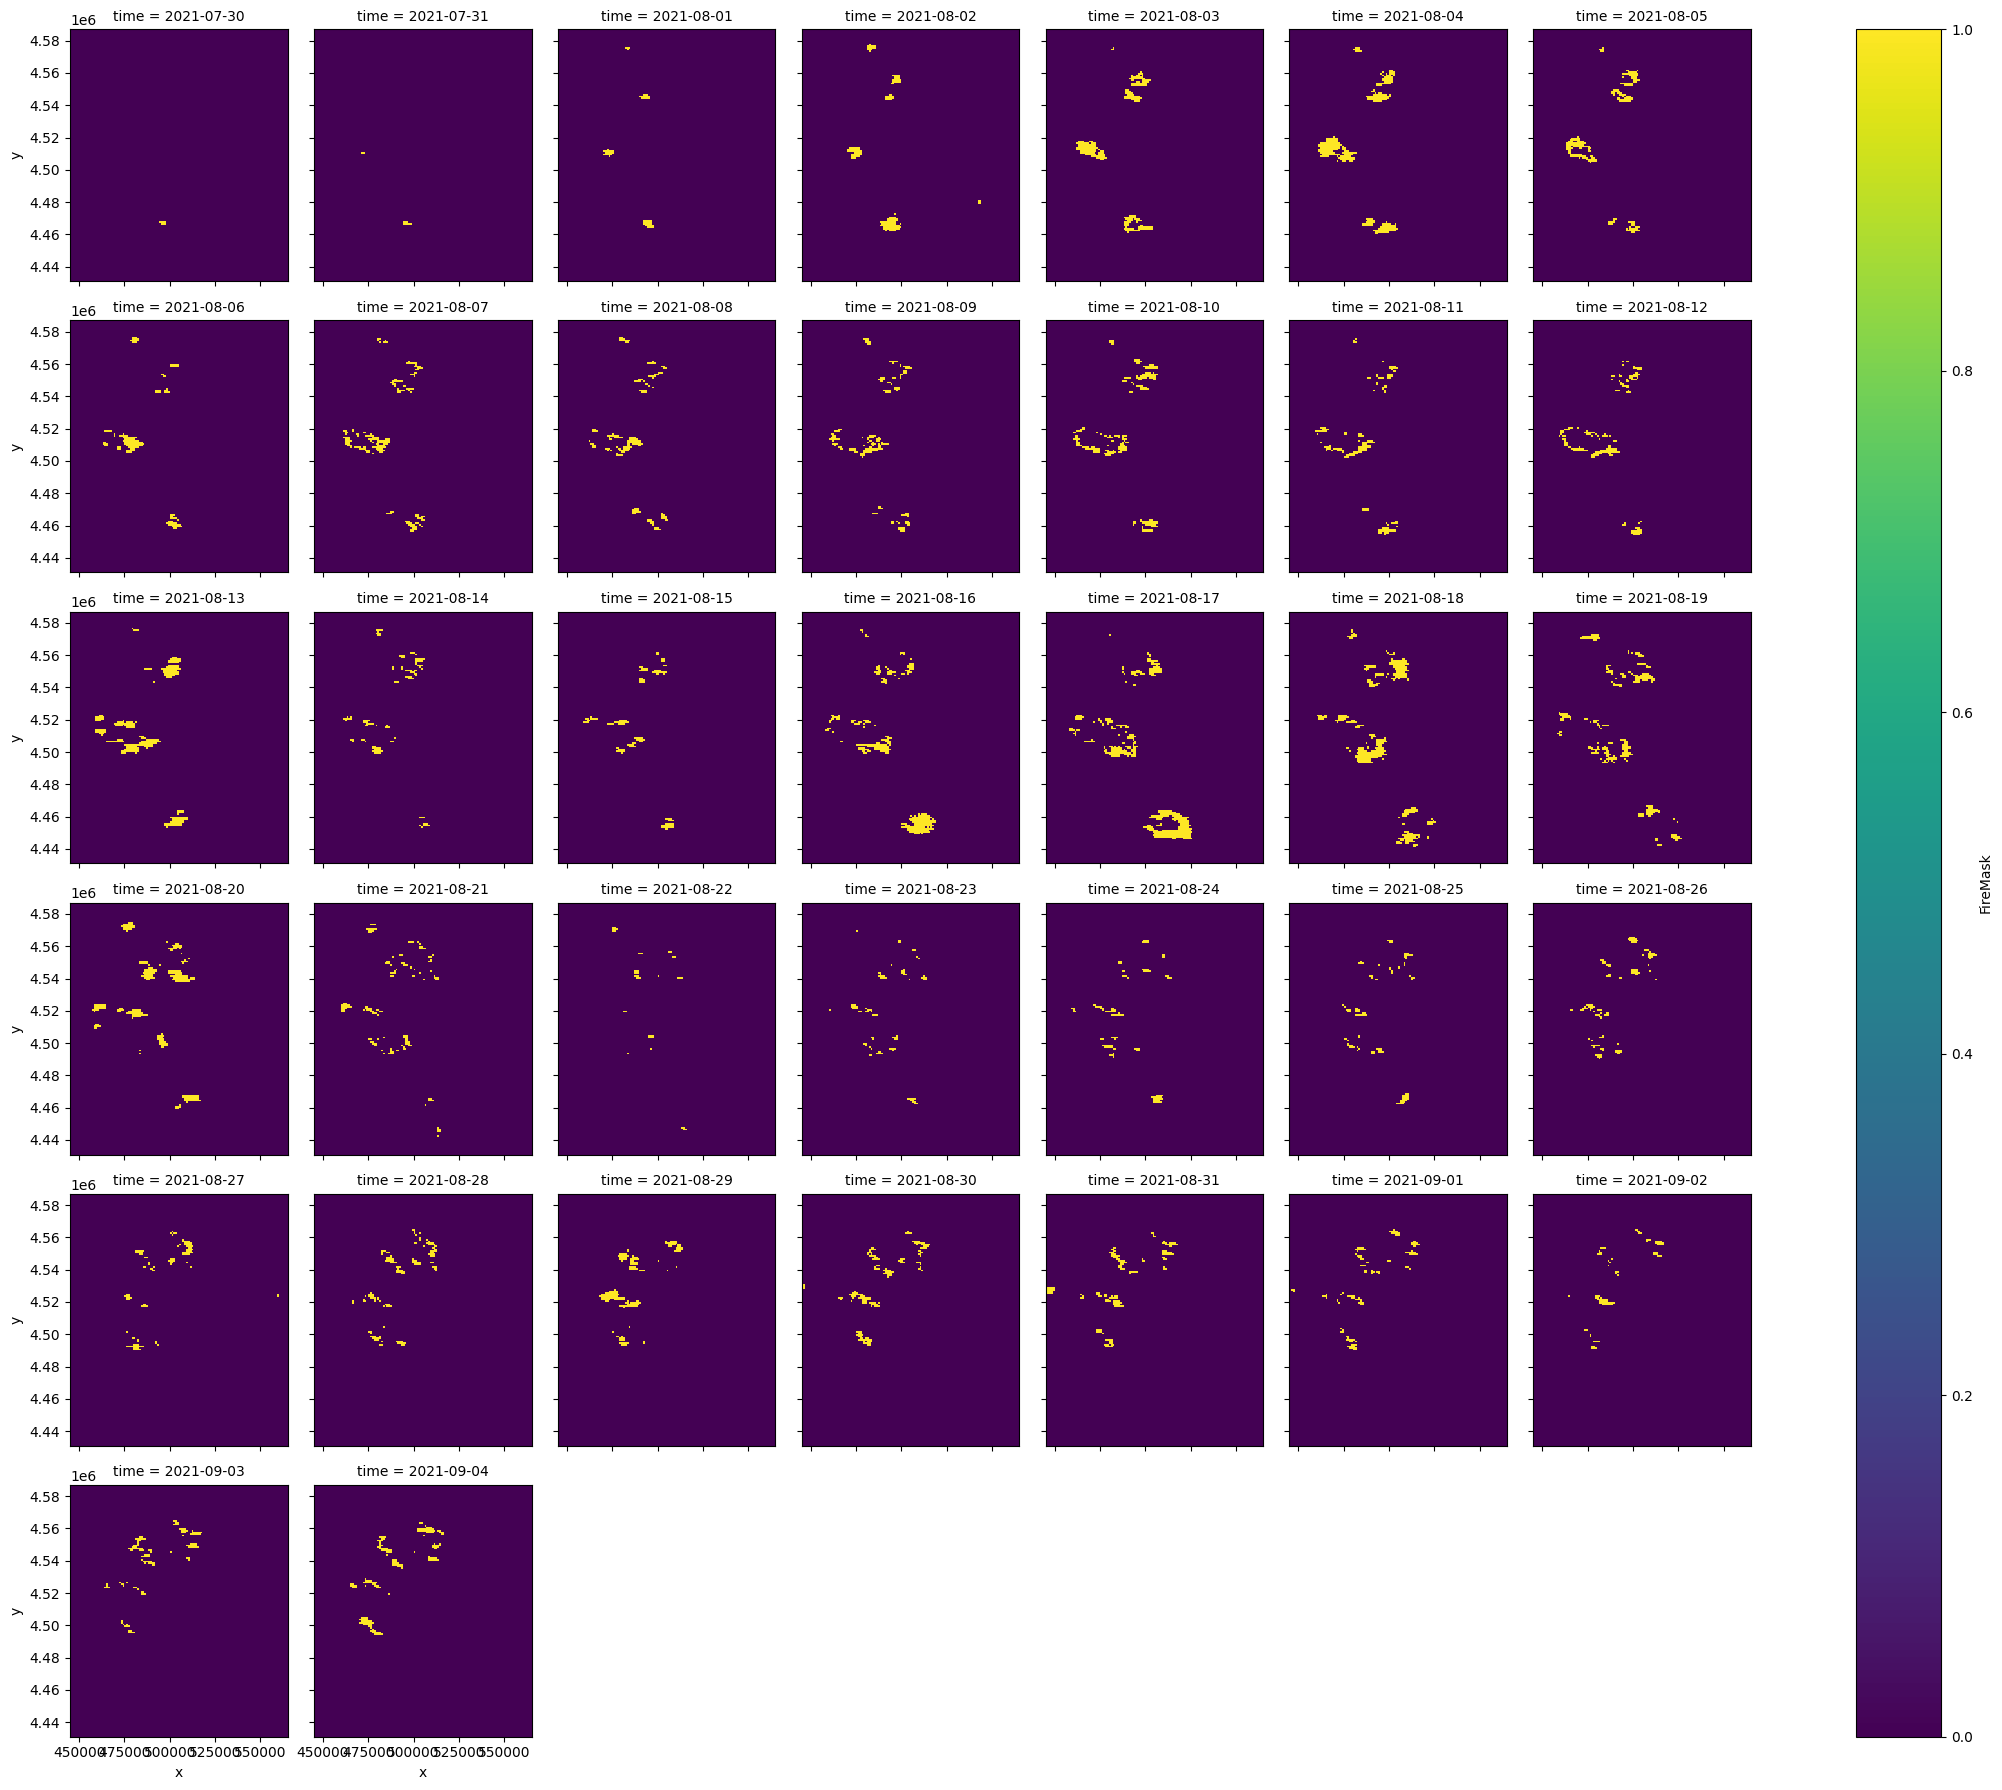

In [20]:
ds.FireMask.plot(col="time", col_wrap=7)

### Mean

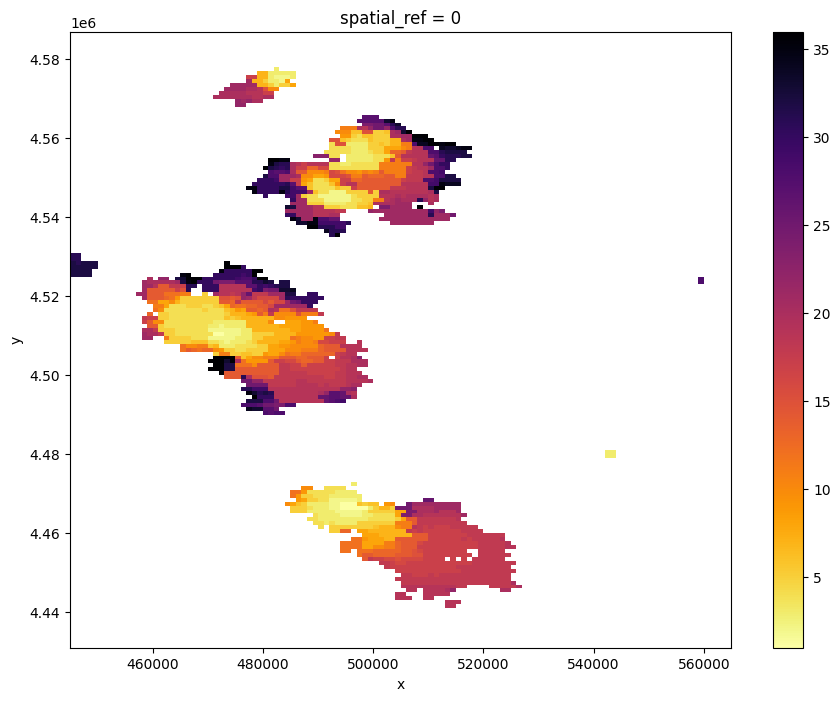

In [21]:
def get_fire_progession(ds):
  start = ds.time.min()
  delta_days = (ds.time - start).dt.days
  delta_days_fire = (ds.FireMask * delta_days).astype(int)
  first_burned = delta_days_fire.where(delta_days_fire != 0).min("time")
  return first_burned


fire_progession = get_fire_progession(ds)
fire_progession.plot(size=8, cmap="inferno_r")

In [22]:
fire_masks_df = fire_masks.dataframe()
fire_masks_df

,MaxFRP_scale,system:id,system:time_start
0,0.1,MODIS/061/MOD14A1/2021_07_30,2021-07-30
1,0.1,MODIS/061/MOD14A1/2021_07_31,2021-07-31
2,0.1,MODIS/061/MOD14A1/2021_08_01,2021-08-01
3,0.1,MODIS/061/MOD14A1/2021_08_02,2021-08-02
4,0.1,MODIS/061/MOD14A1/2021_08_03,2021-08-03
5,0.1,MODIS/061/MOD14A1/2021_08_04,2021-08-04
6,0.1,MODIS/061/MOD14A1/2021_08_05,2021-08-05
7,0.1,MODIS/061/MOD14A1/2021_08_06,2021-08-06
8,0.1,MODIS/061/MOD14A1/2021_08_07,2021-08-07
9,0.1,MODIS/061/MOD14A1/2021_08_08,2021-08-08


In [23]:
import random

sample_image = random.choice(fire_masks_df["system:id"].values)
sample_image

'MODIS/061/MOD14A1/2021_08_14'

In [24]:
img = ee.Image(sample_image).select(["FireMask"])
img

In [25]:
# Clip the image
geom_poly = ee.Geometry.BBox(*bbox)
img = img.clip(geom_poly)

In [26]:
# Conver image to ds: https://geemap.org/notebooks/140_ee_to_xarray/
import geemap
_ds = geemap.ee_to_xarray(img)
_ds

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00


<xarray.Dataset>
Dimensions:   (time: 1, lon: 360, lat: 180)
Coordinates:
  * time      (time) datetime64[ns] 2021-08-14
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    FireMask  (time, lon, lat) int32 ...
Attributes:
    crs:      EPSG:4326

In [27]:
bbox_centroid = geom_poly.centroid(maxError=1)
# display('bbox.centroid(...) =', bbox_centroid)

In [28]:
import geemap

Map = geemap.Map(center=[40.72925142342754, -122.94200000000065, ], zoom=8)

# TODO: https://tutorials.geemap.org/Image/image_visualization/
firemask_vis = {'bands': ['FireMask'],
               #'min': 0,
               #'max': 0.5,
               'gamma': 0.4}

Map.addLayer(img, firemask_vis, "FireMask")


Map

Map(center=[40.72925142342754, -122.94200000000065], controls=(WidgetControl(options=['position', 'transparent…

In [29]:
period_max = fire_masks.aggregate_time("week", reducer=ee.Reducer.max())
period_max

In [30]:
ds = period_max.wx.to_xarray(region=region, scale=1000, crs="EPSG:26910")

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

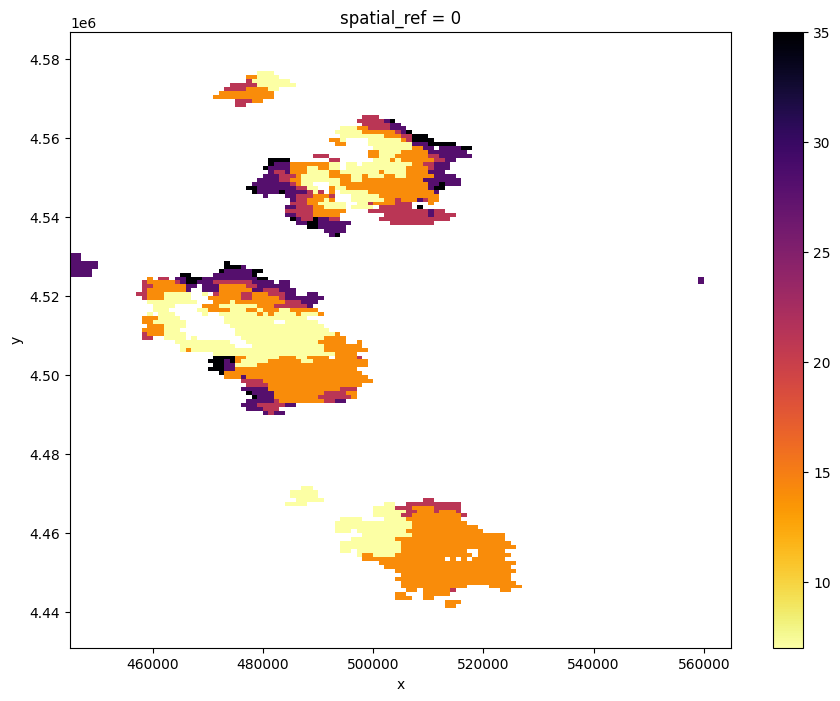

In [31]:
fire_progession = get_fire_progession(ds)
fire_progession.plot(size=8, cmap="inferno_r")

# Download MODIS

https://gis.stackexchange.com/questions/376717/export-multiple-images-from-collection-to-google-drive-not-working-with-google-e

In [119]:
# USDA MODIS ImageCollection
collection = ee.ImageCollection('MODIS/061/MOD14A1')

# create a roi NOT NEEEDED!!!!
polys = ee.Geometry.Polygon(
        [[[37.5, 25.5],
          [40.5, 25.5],
          [40.5, 28.5],
          [37.5, 28.5]]])

# filter the ImageCollection using the roi
modis_collection = collection.filterBounds(region)

# filter dates
modis_dates = modis_collection.filterDate('2021-07-30', '2021-09-05').select("FireMask")
mosaic = modis_dates.mosaic()

# print out the number of images in the ImageCollection
count = modis_dates.size().getInfo()
print("Count: ", count)

Count:  37


In [120]:
# export the ImageCollection to Google Drive
img_lst = modis_dates.toList(100)
img_lst

In [121]:
import time
for i in range(0, count):
    image = ee.Image(img_lst.get(i))
    name = image.get('system:index').getInfo()
    print(name)
    task = ee.batch.Export.image.toDrive(image=image,
                                         region=region,
                                         folder='MODIS_MOD14A1',
                                         scale=30,
                                         crs='EPSG:26910')
 #   task.start()
 #   print(task.status())

 #   while task.active():
 #     print('Waiting on (id: {}).'.format(task.id))
 #     time.sleep(15)


2021_07_30
2021_07_31
2021_08_01
2021_08_02
2021_08_03
2021_08_04
2021_08_05
2021_08_06
2021_08_07
2021_08_08
2021_08_09
2021_08_10
2021_08_11
2021_08_12
2021_08_13
2021_08_14
2021_08_15
2021_08_16
2021_08_17
2021_08_18
2021_08_19
2021_08_20
2021_08_21
2021_08_22
2021_08_23
2021_08_24
2021_08_25
2021_08_26
2021_08_27
2021_08_28
2021_08_29
2021_08_30
2021_08_31
2021_09_01
2021_09_02
2021_09_03
2021_09_04


In [128]:
!ls -al "/content/drive/My Drive/MODIS_MOD14A1"

total 6629
-rw------- 1 root root 180322 Jan 21 14:39 'myExportImageTask (10).tif'
-rw------- 1 root root 180164 Jan 21 14:38 'myExportImageTask (11).tif'
-rw------- 1 root root 182339 Jan 21 14:38 'myExportImageTask (12).tif'
-rw------- 1 root root 174787 Jan 21 14:34 'myExportImageTask (13).tif'
-rw------- 1 root root 185596 Jan 21 14:33 'myExportImageTask (14).tif'
-rw------- 1 root root 185317 Jan 21 14:33 'myExportImageTask (15).tif'
-rw------- 1 root root 189340 Jan 21 14:32 'myExportImageTask (16).tif'
-rw------- 1 root root 193190 Jan 21 14:28 'myExportImageTask (17).tif'
-rw------- 1 root root 193841 Jan 21 14:27 'myExportImageTask (18).tif'
-rw------- 1 root root 190084 Jan 21 14:27 'myExportImageTask (19).tif'
-rw------- 1 root root 181710 Jan 21 14:51 'myExportImageTask (1).tif'
-rw------- 1 root root 180765 Jan 21 14:27 'myExportImageTask (20).tif'
-rw------- 1 root root 181122 Jan 21 14:22 'myExportImageTask (21).tif'
-rw------- 1 root root 191174 Jan 21 14:21 'myExportIm

In [36]:
# TEST
S2 = (ee.ImageCollection('MODIS/061/MOD14A1')
    .filterBounds(region)
    .filterDate('2021-07-30', '2021-09-05')
    #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
    )

del S2

# DataLoader from FireMasks

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from torchvision import transforms

In [38]:
class CustomGeoDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths  # List of file paths for geospatial data
        self.transform = transform  # Data augmentation/transformations

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Open the geospatial file using Rasterio
        with rasterio.open(self.file_paths[idx], 'r') as src:
            data = src.read()  # Read the data (e.g., satellite imagery)
            # TODO
            # label = ...
            # Apply any preprocessing or transformations here
            if self.transform:
                data = self.transform(data)
        return data

In [39]:
# Define the list of file paths to your geospatial data files
import os
from os import listdir
from os.path import isfile, join
path = '/content/drive/My Drive/MODIS_MOD14A1'
file_paths = [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
file_paths[:2]

['/content/drive/My Drive/MODIS_MOD14A1/myExportImageTask (36).tif',
 '/content/drive/My Drive/MODIS_MOD14A1/myExportImageTask (35).tif']

In [40]:
# Instantiate the custom dataset
custom_dataset = CustomGeoDataset(file_paths[:2])

In [41]:
# Define custom data augmentation/transformations
custom_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    # Add more transformations as needed
])

# Instantiate the custom dataset with transformations
# custom_dataset = CustomGeoDataset(file_paths, transform=custom_transforms)

In [42]:
# Create a DataLoader for batching and parallel data loading
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

In [43]:
# FireMasks as tensors
next(iter(dataloader))

tensor([[[[5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          ...,
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5]]],


        [[[5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          ...,
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5]]]], dtype=torch.uint8)



```
for batch in dataloader:
    # Perform model training or inference with the batch data
    # Make sure your model is compatible with the input data format
```



In [44]:
for batch in dataloader:
    print(batch.shape)

torch.Size([2, 1, 5184, 3983])


Crop and preprocess: https://github.com/JenAlchimowicz/Semantic-segmentation-with-PyTorch-Satellite-Imagery/blob/main/data_preprocessing.ipynb

# Download LandCovers

Other method than the one here: https://colab.research.google.com/drive/1zvg-6Qmf_pDcjC0jZYOF5kjxIAONkZpm#scrollTo=oIbAgqDX0BM0

In [122]:
# Sentinel-2 MSI: MultiSpectral Instrument, Level-2A
collection = ee.ImageCollection('COPERNICUS/S2_SR')

# filter the ImageCollection using the roi
sentinel_collection = collection.filterBounds(region)

# filter dates
sentinel_dates = sentinel_collection.filterDate('2021-07-30', '2021-09-05').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).select(["B4", "B3", "B2"])
# mosaic = modis_dates.mosaic()


# print out the number of images in the ImageCollection
count = sentinel_dates.size().getInfo()
print("Count: ", count)

Count:  37


In [123]:
# export the ImageCollection to Google Drive
img_lst = sentinel_dates.toList(100)
img_lst

In [124]:
import time
for i in range(0, 2):
    image = ee.Image(img_lst.get(i))
    name = image.get('system:index').getInfo()
    print(name)
    print(f'{name}' + '_')

20210731T185921_20210731T190632_T10TDK
20210731T185921_20210731T190632_T10TDK_
20210731T185921_20210731T190632_T10TDL
20210731T185921_20210731T190632_T10TDL_


In [127]:
import time
for i in range(0, count):
    image = ee.Image(img_lst.get(i))
    name = image.get('system:index').getInfo()
    print(name)
    task = ee.batch.Export.image.toDrive(image=image,
                                         #description=f'{name}' + '_',
                                         description=name,
                                         region=region,
                                         folder='COPERNICUS_S2_SR',
                                         scale=30,
                                         crs='EPSG:32631')
#    task.start()
#    print(task.status())

#    while task.active():
#      print('Waiting on (id: {}).'.format(task.id))
#      time.sleep(5)

20210731T185921_20210731T190632_T10TDK
20210731T185921_20210731T190632_T10TDL
20210731T185921_20210731T190632_T10TEK
20210802T184919_20210802T185957_T10TEK
20210802T184919_20210802T185957_T10TEL
20210805T185919_20210805T190825_T10TDK
20210805T185919_20210805T190825_T10TEK
20210807T184921_20210807T185412_T10TEL
20210810T185921_20210810T190502_T10TDK
20210810T185921_20210810T190502_T10TEK
20210810T185921_20210810T190502_T10TEL
20210815T185919_20210815T190832_T10TDK
20210815T185919_20210815T190832_T10TDL
20210815T185919_20210815T190832_T10TEK
20210815T185919_20210815T190832_T10TEL
20210820T185921_20210820T190523_T10TDL
20210820T185921_20210820T190523_T10TEK
20210820T185921_20210820T190523_T10TEL
20210820T185921_20210820T191316_T10TDK
20210820T185921_20210820T191316_T10TEK
20210822T184919_20210822T190056_T10TEK
20210822T184919_20210822T190056_T10TEL
20210825T185919_20210825T190431_T10TDK
20210825T185919_20210825T190431_T10TDL
20210825T185919_20210825T190431_T10TEK
20210827T184921_20210827T

In [49]:
import os
from os import listdir
from os.path import isfile, join
path = '/content/drive/My Drive/COPERNICUS_S2_SR'
file_paths = [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
file_paths[:2]

[]

In [126]:
!ls -al '/content/drive/My Drive/COPERNICUS_S2_SR'

total 0


# other way to download

In [50]:
region

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -122.24199999999999,
              40.031
            ],
            [
              -122.24199999999999,
              41.431000000000004
            ],
            [
              -123.642,
              41.431000000000004
            ],
            [
              -123.642,
              40.031
            ],
            [
              -122.24199999999999,
              40.031
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

https://geedim.readthedocs.io/en/latest/examples/s2_composite.html

https://gis.stackexchange.com/questions/460366/gee-downloads-two-sentinel-2-images-per-tile-instead-of-one

TODO: https://courses.spatialthoughts.com/end-to-end-gee.html


EE asset ids for Sentinel-2 L2 assets have the following format: COPERNICUS/S2_SR/20151128T002653_20151128T102149_T56MNN. Here the first numeric part represents the sensing date and time, the second numeric part represents the product generation date and time, and the final 6-character string is a unique granule identifier indicating its UTM grid reference (see MGRS).

`20210805T185919_20210805T190825_T10TDK.tif`

https://www.map.army/ => Coordinate grid:. MGRS

In [130]:
region

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -122.24199999999999,
              40.031
            ],
            [
              -122.24199999999999,
              41.431000000000004
            ],
            [
              -123.642,
              41.431000000000004
            ],
            [
              -123.642,
              40.031
            ],
            [
              -122.24199999999999,
              40.031
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [51]:
import geemap
start = ee.Date('2021-08-03')
end = ee.Date('2021-08-06')

collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(region)
    #.filterDate('2021-08-03', '2021-08-06')
    .filterDate(start, end)
    .filter(ee.Filter.listContains("system:band_names", "B4"))
    .filter(ee.Filter.listContains("system:band_names", "B3"))
    .filter(ee.Filter.listContains("system:band_names", "B2"))
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .select(['B2', 'B3', 'B4', 'TCI_R', 'TCI_G', 'TCI_B'])
)

# collection.max()

# print out the number of images in the ImageCollection
count = collection.size().getInfo()
print("Count: ", count)

out_dir = '/content/drive/My Drive/COPERNICUS_S2_SR_ee'
geemap.download_ee_image_collection(collection, out_dir, scale=100)

Count:  2
Total number of images: 2



20210805T185919_20210805T190825_T10TDK.tif: |          | 0.00/14.5M (raw) [  0.0%] in 00:00 (eta:     ?)

20210805T185919_20210805T190825_T10TEK.tif: |          | 0.00/14.5M (raw) [  0.0%] in 00:00 (eta:     ?)

TODO: How to divide a large image into smaller tiles and download them automatically:


*   https://www.youtube.com/watch?v=hWDvzBfr6SU
*   https://geemap.org/notebooks/118_download_image/
*   https://github.com/leftfield-geospatial/geedim
*   Tiles: https://geemap.org/notebooks/118_download_image/?query=download_ee_image_collection#download-image-by-tile





In [52]:
import os
from os import listdir
from os.path import isfile, join
path = out_dir
file_paths = [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
file_paths[:2]

['/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif',
 '/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TEK.tif']

In [53]:
import glob
print(path)
for file in glob.glob('/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif'):
    print(file)

/content/drive/My Drive/COPERNICUS_S2_SR_ee
/content/drive/My Drive/COPERNICUS_S2_SR_ee/20210805T185919_20210805T190825_T10TDK.tif


If your data only contains image files, as is the case with Sentinel-2, use is_image = True. If your data only contains segmentation masks, use is_image = False instead.

In [114]:
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#torchgeo.datasets.Sentinel2

import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler, Units

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
class Sentinel2(RasterDataset):
    filename_glob = "*.tif"
    #filename_regex = "^(?P<date>\d{8}T\d{6})_(?P<date2>\d{8}T\d{6})_T10(\w{3})\.tif$"
    #filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    #date_format = "%Y%m%dT%H%M%S"
    #is_image = True
    #separate_files = True
    all_bands = ["B02", "B03", "B04"]
    rgb_bands = ["B04", "B03", "B02"]
    # all_bands = ["TCI_R", "TCI_G", "TCI_B"]
    # rgb_bands =  ["TCI_R", "TCI_G", "TCI_B"]

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()

        print(rgb_indices)
        print(image.shape)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        # plt.imshow(rgb*3)
        return fig

    def plot_sample(self, sample):
      # max:65535 pixels => collection.max() output
      arr = torch.clamp(sample['image']/10000, min=0, max=1).numpy()
      rgb = arr.transpose(2, 1, 0)[:, :, [2, 1 , 0]]

      # Plot the image
      fig, ax = plt.subplots()
      ax.imshow(rgb*3)

      # plt.imshow(rgb*3)
      return fig

from pathlib import Path
root = Path('/content/drive/My Drive/COPERNICUS_S2_SR_ee')
assert root.exists()

dataset = Sentinel2(paths=root.as_posix(), crs='epsg:3395', res=10)
# dataset = Sentinel2(paths=root.as_posix(), crs='epsg:4326', res=10)

print(dataset)
sampler = RandomGeoSampler(dataset, size=512, length=30, units=Units.PIXELS)
dataloader = DataLoader(dataset, sampler=sampler, batch_size=8, collate_fn=stack_samples)


Sentinel2 Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=-13824088.290041966, maxx=-13547742.27272746, miny=4788320.486490982, maxy=4933268.657340629, mint=0.0, maxt=9.223372036854776e+18)
    size: 2


In [109]:
for sample in dataloader:
    image = sample['image']
    print(image.shape)
    image = torch.squeeze(image)
    print(image.T.shape)
    plt.imshow(image.T, cmap='bone', vmin=-35, vmax=-5)

RuntimeError: cannot sample n_sample > prob_dist.size(-1) samples without replacement

[2, 1, 0]
(512, 512, 3)


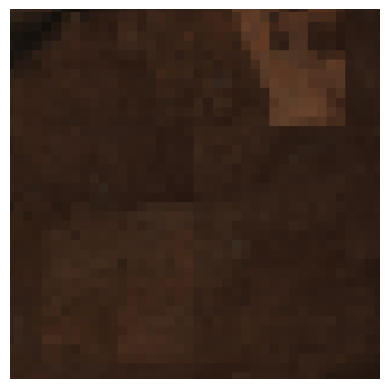

[2, 1, 0]
(512, 512, 3)


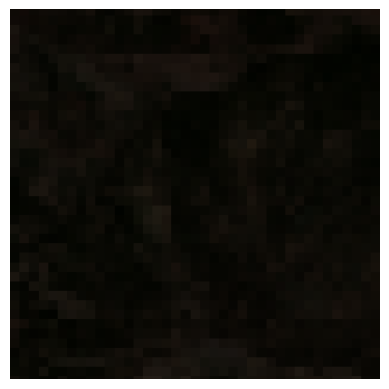

[2, 1, 0]
(512, 512, 3)


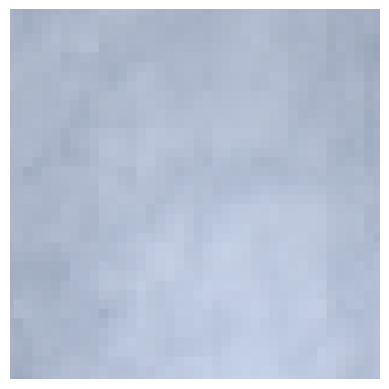

[2, 1, 0]
(512, 512, 3)


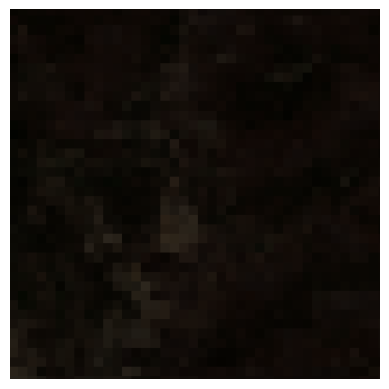

In [131]:
# next(iter(dataloader))
# for batch in dataloader:
#    print(batch)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [57]:
torch.manual_seed(1)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# TODO: Fix
# sampler = RandomGeoSampler(dataset, size=4096, length=3)
# dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

In [58]:
for batch in dataloader:
    print(batch.shape)

TypeError: 'int' object is not iterable

https://towardsdatascience.com/artificial-intelligence-for-geospatial-analysis-with-pytorchs-torchgeo-part-2-ec3785fae284

In [59]:
from pathlib import Path
root = Path('/content/drive/My Drive/COPERNICUS_S2_SR_ee')
assert root.exists()

train_imgs = RasterDataset(paths=root.as_posix(), crs='epsg:3395', res=10)
#train_msks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='epsg:3395', res=10)

# IMPORTANT
#train_msks.is_image = False

In [60]:
train_imgs = RasterDataset(paths=root.as_posix(), crs='epsg:3395', res=10)

In [61]:
from torchgeo.samplers import RandomGeoSampler, Units
sampler = RandomGeoSampler(train_imgs, size=512, length=30, units=Units.PIXELS)

In [62]:
_bbox = next(iter(sampler))
_bbox

BoundingBox(minx=-13589896.475944592, maxx=-13584776.475944592, miny=4792414.6337356735, maxy=4797534.6337356735, mint=0.0, maxt=9.223372036854776e+18)

In [63]:
img_sample = train_imgs[_bbox]
# msk_sample = train_msks[_bbox]

#print(img_sample.keys(), msk_sample.keys())

print(img_sample.keys())
print(img_sample['image'].shape)

dict_keys(['crs', 'bbox', 'image'])
torch.Size([6, 512, 512])


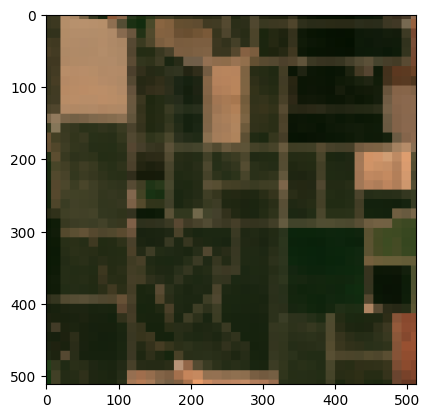

In [64]:
import torch
import matplotlib.pyplot as plt

arr = torch.clamp(img_sample['image']/10000, min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [2, 1 , 0]]

plt.imshow(rgb*3)

In [65]:
print(img_sample['bbox'])

BoundingBox(minx=-13589896.475944592, maxx=-13584776.475944592, miny=4792414.6337356735, maxy=4797534.6337356735, mint=0.0, maxt=9.223372036854776e+18)


In [66]:
# train_dset = train_imgs & train_msks

train_dset = train_imgs

In [67]:
sample = train_dset[_bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image'])

In [68]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'image'])

In [71]:
# for batch in dataloader:
#     sample = unbind_samples(batch)[0]
#     train_imgs.plot(sample)
#     plt.axis("off")
#     plt.show()

In [70]:
for batch in dataloader:
    print(batch)

defaultdict(<class 'list'>, {'crs': ['epsg:3395', 'epsg:3395', 'epsg:3395', 'epsg:3395', 'epsg:3395', 'epsg:3395', 'epsg:3395', 'epsg:3395'], 'bbox': [BoundingBox(minx=-13667756.211304737, maxx=-13662636.211304737, miny=4903640.149244325, maxy=4908760.149244325, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=-13692420.761035962, maxx=-13687300.761035962, miny=4819143.46337457, maxy=4824263.46337457, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=-13624000.809094978, maxx=-13618880.809094978, miny=4868441.365374582, maxy=4873561.365374582, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=-13672166.490097119, maxx=-13667046.490097119, miny=4896261.845246809, maxy=4901381.845246809, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=-13588563.365278317, maxx=-13583443.365278317, miny=4862216.0510733295, maxy=4867336.0510733295, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=-13738964.45745377, maxx=-13733844.45745377, miny=4883695.973016217, maxy=488

In [72]:
from typing import Iterable, List
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())

    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore

        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

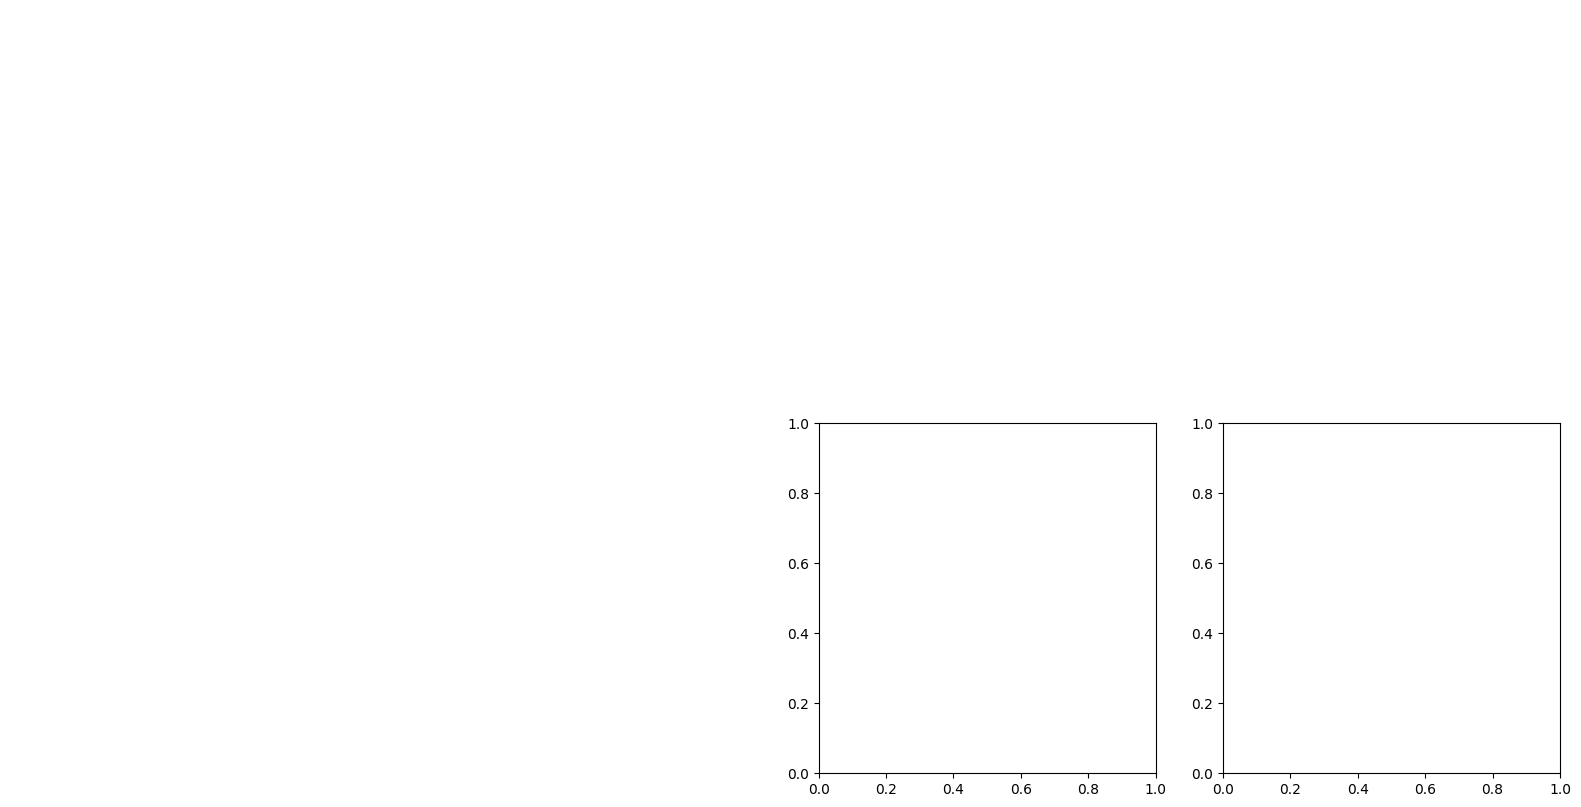

In [73]:
plot_batch(batch)